In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

from tf2_utils import load_npy_data

jtplot.style()

%load_ext lab_black

DATA_FPATH = "data"
CLASSICAL_FPATH = "CP_C"
POP_FPATH = "CP_P"

# Load a sample of the data

The method used below is the same method used in `CycleGAN.load`. We get a tensor of shape `(batch_size, n_bars * time_steps, pitch_range, 2)` where `batch_size` is just the sample size in this case, `n_bars` is the number of bars the sample contains (4), `time_steps` is the number of time steps per bar (16) and `pitch_range` marks the # of pitches allowed (C1 to C8). The 2 shows us that we have one entry for each genre (`DATA1` and `DATA2`), which we split into their own tensors.

In [2]:
sample_size = 5

classical_fnames = glob(os.path.join(DATA_FPATH, CLASSICAL_FPATH, "train", "*"))[
    :sample_size
]
pop_fnames = glob(os.path.join(DATA_FPATH, POP_FPATH, "train", "*"))[:sample_size]
all_fnames = zip(classical_fnames, pop_fnames)

dataset = np.array([load_npy_data(fname) for fname in all_fnames], dtype=np.float32)
print(f"Loaded data shape: {dataset.shape}")

classical = dataset[:, :, :, 0].squeeze()
pop = dataset[:, :, :, 1].squeeze()
print(f"classical shape: {classical.shape}")
print(f"pop shape: {pop.shape}")

Loaded data shape: (5, 64, 84, 2)
classical shape: (5, 64, 84)
pop shape: (5, 64, 84)


In [3]:
def plot_samples(samples, names=["classical", "pop"]):
    def plot_hlines(ax):
        for step in range(0, 65, 16)[::-1]:
            ax.hlines(step, 0, 84, linestyle="--")

    data1, data2 = samples
    name1, name2 = names

    fig, axes = plt.subplots(
        data1.shape[0], 2, figsize=(12, 14), sharex=True, sharey=True
    )

    for idx, (ax1, ax2) in enumerate(axes):
        ax1.imshow(data1[idx])
        ax1.set_title(f"{name1} - sample {idx}")
        ax1.set_ylabel("time step")
        plot_hlines(ax1)
        ax1.set_xlim([0, 84])
        ax1.set_ylim([0, 64])
        ax2.imshow(data2[idx])
        ax2.set_title(f"{name2} - sample {idx}")

        plot_hlines(ax2)
        ax2.set_xlim([0, 84])
        ax2.set_ylim([0, 64])
    ax1.set_xlabel("pitch")
    ax2.set_xlabel("pitch")
    fig.tight_layout()
    plt.show()

In the plot below, the blue dashed lines denote the end of a bar (16 time steps)

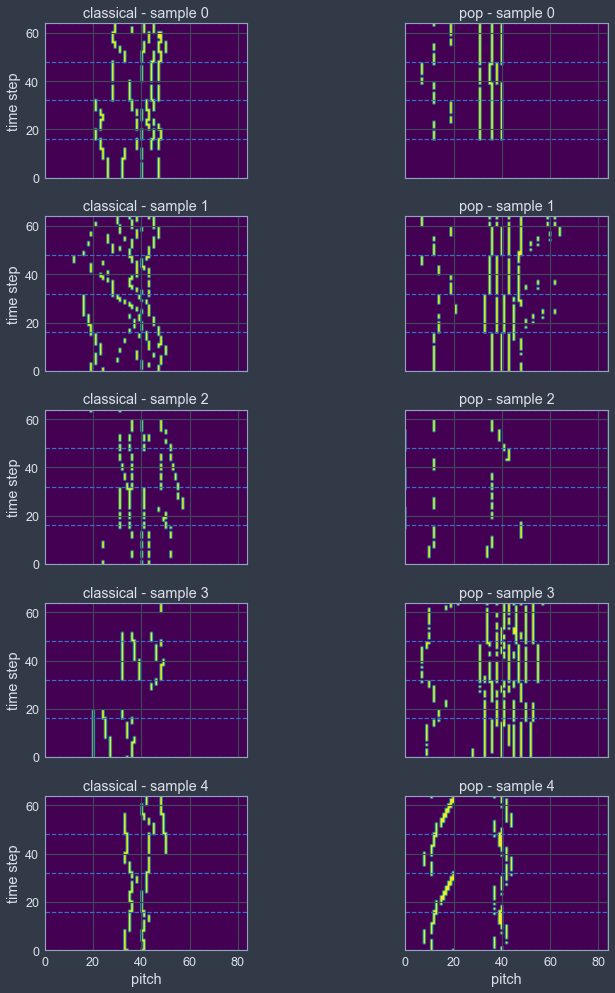

In [4]:
plot_samples([classical, pop])

As these samples show, there is a lot of variation in between the datasets but also between samples of the same dataset. 

The pop dataset already shows some repetition in the 4 bars, while the classical doesn't (except perhaps sample 3).

Note that the data is represented with time steps on the y-axis and pitches on the x-axis.

There is no pre-processing done on the fly (i.e. just before training). The preprocessing is done beforehand to save time.

# Following preparation steps

As outlined in the original git repo, if we want to use a new dataset for CycleGAN, or change the preparation steps, we need to run through the steps outlined in `Testfile.py`. Which is what I'll do now. For this example I'll use the data from ChordGAN.

## 1. divide the original set into train and test sets

In [5]:
import shutil

ROOT_PATH = "new_data"
GENRE_PATH = "Pop_Music_Midi"
TEST_RATIO = 0.1

converter_path = os.path.join(ROOT_PATH, "test/converter")
cleaner_path = os.path.join(ROOT_PATH, "test/cleaner")

In [6]:
filenames = [f for f in os.listdir(os.path.join(ROOT_PATH, GENRE_PATH))]
idx = np.random.choice(len(filenames), int(TEST_RATIO * len(filenames)), replace=False)
print(len(idx), "files saved for test")
for i in idx:
    shutil.move(
        os.path.join(ROOT_PATH, GENRE_PATH, filenames[i]),
        os.path.join(ROOT_PATH, "test", "origin_midi", filenames[i]),
    )

7 files saved for test


## 2. Run `convert_clean.py`

I'll run this step by step, starting from

### 2a - main()

In [7]:
from pypianoroll import Multitrack, Track, from_pretty_midi
import pretty_midi
import errno
import json

In [8]:
def get_midi_path(root):
    """Return a list of paths to MIDI files in `root` (recursively)"""
    filepaths = []
    for dirpath, _, filenames in os.walk(root):
        for filename in filenames:
            if ".mid" in filename:
                filepaths.append(os.path.join(dirpath, filename))
    return filepaths


midi_paths = get_midi_path(os.path.join(ROOT_PATH, "test/origin_midi"))
print(f"Found {len(midi_paths)} midi files")

Found 56 midi files


In [9]:
def make_sure_path_exists(path):
    """Create all intermediate-level directories if the given path does not
    exist"""
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise


def get_midi_info(pm):
    """Return useful information from a pretty_midi.PrettyMIDI instance"""
    if pm.time_signature_changes:
        pm.time_signature_changes.sort(key=lambda x: x.time)
        first_beat_time = pm.time_signature_changes[0].time
    else:
        first_beat_time = pm.estimate_beat_start()

    tc_times, tempi = pm.get_tempo_changes()

    if len(pm.time_signature_changes) == 1:
        time_sign = "{}/{}".format(
            pm.time_signature_changes[0].numerator,
            pm.time_signature_changes[0].denominator,
        )
    else:
        time_sign = None

    midi_info = {
        "first_beat_time": first_beat_time,
        "num_time_signature_change": len(pm.time_signature_changes),
        "time_signature": time_sign,
        "tempo": tempi[0] if len(tc_times) == 1 else None,
    }

    return midi_info

In [10]:
sample_fpath = midi_paths[10]
sample_pm = pretty_midi.PrettyMIDI(sample_fpath)
sample_midi_info = get_midi_info(sample_pm)
sample_midi_info

C:\Users\gamin\anaconda3\envs\cyclegan\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


{'first_beat_time': 0.0,
 'num_time_signature_change': 1,
 'time_signature': '4/4',
 'tempo': 120.0}

I had to modify `get_merged` since the Pypianoroll API changed and the `get_merged_pianoroll()` was renamed to `blend()`. In addition I had to create a new temporary track to blend the pianorolls for each category.

In [11]:
def get_merged(multitrack):
    """Return a `pypianoroll.Multitrack` instance with piano-rolls merged to
    five tracks (Bass, Drums, Guitar, Piano and Strings)"""
    category_list = {"Bass": [], "Drums": [], "Guitar": [], "Piano": [], "Strings": []}
    program_dict = {"Piano": 0, "Drums": 0, "Guitar": 24, "Bass": 32, "Strings": 48}

    for idx, track in enumerate(multitrack.tracks):
        if track.is_drum:
            category_list["Drums"].append(idx)
        elif track.program // 8 == 0:
            category_list["Piano"].append(idx)
        elif track.program // 8 == 3:
            category_list["Guitar"].append(idx)
        elif track.program // 8 == 4:
            category_list["Bass"].append(idx)
        else:
            category_list["Strings"].append(idx)

    tracks = []
    for key in category_list:
        if category_list[key]:
            pianoroll = Multitrack(
                tracks=[multitrack[i] for i in category_list[key]]
            ).blend()
        else:
            pianoroll = None
        tracks.append(
            Track(
                pianoroll=pianoroll,
                program=program_dict[key],
                is_drum=key == "Drums",
                name=key,
            )
        )
    return Multitrack(
        tracks=tracks,
        tempo=multitrack.tempo,
        downbeat=multitrack.downbeat,
        resolution=multitrack.resolution,
        name=multitrack.name,
    )


def converter(filepath):
    """Save a multi-track piano-roll converted from a MIDI file to target
    dataset directory and update MIDI information to `midi_dict`"""
    midi_name = os.path.splitext(os.path.basename(filepath))[0]

    try:
        # Create the multitrack object
        multitrack = Multitrack(resolution=24, name=midi_name)

        pm = pretty_midi.PrettyMIDI(filepath)
        midi_info = get_midi_info(pm)

        # This adds the pianoroll to the multitrack
        multitrack = from_pretty_midi(pm)
        merged = get_merged(multitrack)

        make_sure_path_exists(converter_path)
        merged.save(os.path.join(converter_path, midi_name + ".npz"))

        return [midi_name, midi_info]

    except TypeError:
        print(f"There was a type error when loading {midi_name}")
        return None

In [12]:
sample_multitrack = get_merged(from_pretty_midi(sample_pm))

In [13]:
midi_dict = {}
kv_pairs = [converter(midi_path) for midi_path in midi_paths]
for kv_pair in kv_pairs:
    if kv_pair is not None:
        midi_dict[kv_pair[0]] = kv_pair[1]

# Saves metadata as json
with open(os.path.join(ROOT_PATH, "test/midis.json"), "w") as outfile:
    json.dump(midi_dict, outfile)

print(
    "[Done] {} files out of {} have been successfully converted".format(
        len(midi_dict), len(midi_paths)
    )
)

[Done] 56 files out of 56 have been successfully converted


In [14]:
def midi_filter(midi_info):
    """Return True for qualified midi files and False for unwanted ones"""
    if midi_info["first_beat_time"] > 0.0:
        return False
    elif midi_info["num_time_signature_change"] > 1:
        return False
    elif midi_info["time_signature"] not in ["4/4"]:
        return False
    return True


with open(os.path.join(ROOT_PATH, "test/midis.json")) as infile:
    midi_dict = json.load(infile)

count = 0
make_sure_path_exists(cleaner_path)
midi_dict_clean = {}
for key in midi_dict:
    if midi_filter(midi_dict[key]):  # This is the crux of the filtering of the files
        midi_dict_clean[key] = midi_dict[key]
        count += 1
        shutil.copyfile(
            os.path.join(converter_path, key + ".npz"),
            os.path.join(cleaner_path, key + ".npz"),
        )

with open(os.path.join(ROOT_PATH, "test/midis_clean.json"), "w") as outfile:
    json.dump(midi_dict_clean, outfile)

print(
    "[Done] {} files out of {} have been successfully cleaned".format(
        count, len(midi_dict)
    )
)

[Done] 56 files out of 56 have been successfully cleaned


## 3. Choose the clean midi from the original datasets

Note: I had to add the `i` to the extension:

TODO: Create a more efficient way of identifying the extensions

In [15]:
if not os.path.exists(os.path.join(ROOT_PATH, "test/cleaner_midi")):
    os.makedirs(os.path.join(ROOT_PATH, "test/cleaner_midi"))

l = [f for f in os.listdir(os.path.join(ROOT_PATH, "test/cleaner"))]
print("Found", len(l), "clean files")
for i in l:
    shutil.copy(
        os.path.join(ROOT_PATH, "test/origin_midi", os.path.splitext(i)[0] + ".midi"),
        os.path.join(ROOT_PATH, "test/cleaner_midi", os.path.splitext(i)[0] + ".midi"),
    )

Found 49 clean files
All The Small Things - Chorus.npz
Baby One More Time - Chorus.npz
Blank Space - Chorus.npz
Blank Space - Pre Chorus.npz
Blank Space - Verse.npz
Call Me Maybe - Chorus.npz
Can You Feel the Love Tonight - Verse.npz
Clocks - Verse.npz
Dancing Queen - Chorus.npz
Dark Horse - Chorus.npz
Die Young - Chorus.npz
Die Young - Verse.npz
Fix You - Verse.npz
Genie in a Bottle - Verse.npz
Girl On Fire - Verse.npz
I Gotta Feeling - Chorus.npz
I Kissed A Girl - Chorus.npz
I Kissed A Girl - Verse.npz
I Need Your Love - Verse.npz
I Want It That Way - Chorus.npz
Locked Out Of Heaven - Pre Chorus.npz
Love Me Harder ft The Weeknd - Chorus.npz
Love Me Harder ft The Weeknd - Pre Chorus.npz
Love Me Harder ft The Weeknd - Verse.npz
Love Story - Chorus.npz
Love Story - Verse.npz
Mr Saxobeat - Verse.npz
Pompeii - Chorus.npz
Pompeii - Verse.npz
Put Your Records On - Chorus.npz
Roar - Verse.npz
Rock That Body - Chorus.npz
Rolling In The Deep - Chorus.npz
Rolling In The Deep - Pre Chorus.npz
Sa

# 4. Merge and crop

In [16]:
if not os.path.exists(os.path.join(ROOT_PATH, "test/cleaner_midi_gen")):
    os.makedirs(os.path.join(ROOT_PATH, "test/cleaner_midi_gen"))

if not os.path.exists(os.path.join(ROOT_PATH, "test/cleaner_npy")):
    os.makedirs(os.path.join(ROOT_PATH, "test/cleaner_npy"))

l = [f for f in os.listdir(os.path.join(ROOT_PATH, "test/cleaner_midi"))]

In [17]:
import write_midi

LAST_BAR_MODE = "remove"


def get_bar_piano_roll(piano_roll):
    if int(piano_roll.shape[0] % 64) != 0:
        # Check that the number of time_steps is multiple of 4*16 (bars* required_time_steps)
        if LAST_BAR_MODE == "fill":
            # Fill time steps with zeros
            piano_roll = np.concatenate(
                (piano_roll, np.zeros((64 - piano_roll.shape[0] % 64, 128))), axis=0
            )

        elif LAST_BAR_MODE == "remove":
            # Delete leftover time steps
            piano_roll = np.delete(
                piano_roll, np.s_[-int(piano_roll.shape[0] % 64) :], axis=0
            )
    piano_roll = piano_roll.reshape(-1, 64, 128)
    return piano_roll


# This comes from `tf2_utils`
def save_midis(bars, file_path, tempo=80.0):
    padded_bars = np.concatenate(
        (
            np.zeros((bars.shape[0], bars.shape[1], 24, bars.shape[3])),
            bars,
            np.zeros((bars.shape[0], bars.shape[1], 20, bars.shape[3])),
        ),
        axis=2,
    )
    padded_bars = padded_bars.reshape(
        -1, 64, padded_bars.shape[2], padded_bars.shape[3]
    )
    padded_bars_list = []
    for ch_idx in range(padded_bars.shape[3]):
        padded_bars_list.append(
            padded_bars[:, :, :, ch_idx].reshape(
                padded_bars.shape[0], padded_bars.shape[1], padded_bars.shape[2]
            )
        )
    # this is for multi-track version
    # write_midi.write_piano_rolls_to_midi(padded_bars_list, program_nums=[33, 0, 25, 49, 0],
    #                                      is_drum=[False, True, False, False, False], filename=file_path, tempo=80.0)

    # this is for single-track version
    write_midi.write_piano_rolls_to_midi(
        piano_rolls=padded_bars_list,
        program_nums=[0],
        is_drum=[False],
        filename=file_path,
        tempo=tempo,
        beat_resolution=4,
    )

In [19]:
count = 0
for i in range(len(l)):
    try:
        x = pretty_midi.PrettyMIDI(os.path.join(ROOT_PATH, "test/cleaner_midi", l[i]))
        multitrack = from_pretty_midi(x, resolution=4)
        multitrack.name = os.path.splitext(l[i])[0]

        category_list = {"Piano": [], "Drums": []}
        program_dict = {"Piano": 0, "Drums": 0}

        for idx, track in enumerate(multitrack.tracks):
            if track.is_drum:
                category_list["Drums"].append(idx)
            else:
                category_list["Piano"].append(idx)
        tracks = []
        # merged = multitrack[category_list["Piano"]].get_merged_pianoroll()
        merged = Multitrack(
            tracks=[multitrack[i] for i in category_list["Piano"]]
        ).blend()
        print("Merged shape", merged.shape)

        pr = get_bar_piano_roll(merged)
        print("Piano roll shape", pr.shape)
        pr_clip = pr[:, :, 24:108]
        print("Clipped PR shape", pr_clip.shape)

        if int(pr_clip.shape[0] % 4) != 0:
            # Keep all bars if there are 4, or a single phrase if there's only 1
            pr_clip = np.delete(pr_clip, np.s_[-int(pr_clip.shape[0] % 4) :], axis=0)
        pr_re = pr_clip.reshape(-1, 64, 84, 1)
        print("Final pr shape", pr_re.shape)

        save_midis(
            pr_re,
            os.path.join(
                ROOT_PATH, "test/cleaner_midi_gen", os.path.splitext(l[i])[0] + ".mid"
            ),
        )
        np.save(
            os.path.join(
                ROOT_PATH, "test/cleaner_npy", os.path.splitext(l[i])[0] + ".npy"
            ),
            pr_re,
        )
        print()
    except Exception as e:
        count += 1
        print("Wrong", l[i])
        print("Error: ")
        raise e
        continue
print("Error count", count)

Merged shape (256, 128)
Piano roll shape (4, 64, 128)
Clipped PR shape (4, 64, 84)
Final pr shape (4, 64, 84, 1)

Merged shape (128, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (128, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (128, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (128, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (64, 128)
Piano roll shape (1, 64, 128)
Clipped PR shape (1, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (128, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (64, 128)
Piano roll shape (1, 64, 128)
Clipped PR shape (1, 64, 84)
Final pr shape (0, 64, 84, 1)

Merged shape (160, 128)
Piano roll shape (2, 64, 128)
Clipped PR shape (2, 64, 84)
Final p

# 5. concatenate into a big numpy binary file

In [24]:
l = [f for f in os.listdir(os.path.join(ROOT_PATH, "test/cleaner_npy"))]
# This is not really a train file, I'm guessing it wasn't renamed correctly
train = np.load(os.path.join(ROOT_PATH, "test/cleaner_npy", l[0]))
print(train.shape, np.max(train))

for i in range(1, len(l)):
    print(i, l[i])
    t = np.load(os.path.join(ROOT_PATH, "test/cleaner_npy", l[i]))
    train = np.concatenate((train, t), axis=0)
print(train.shape)

# This saves the arrays as boolean arrays, I think to make the velocities 0/1
# If needed, to convert to int/float just multiply by 1
np.save(os.path.join(ROOT_PATH, "test/pop_test_piano.npy"), (train > 0.0))

(4, 64, 84, 1) 127
1 Baby One More Time - Chorus.npy
2 Blank Space - Chorus.npy
3 Blank Space - Pre Chorus.npy
4 Blank Space - Verse.npy
5 Call Me Maybe - Chorus.npy
6 Can You Feel the Love Tonight - Verse.npy
7 Clocks - Verse.npy
8 Dancing Queen - Chorus.npy
9 Dark Horse - Chorus.npy
10 Die Young - Chorus.npy
11 Die Young - Verse.npy
12 Fix You - Verse.npy
13 Genie in a Bottle - Verse.npy
14 Girl On Fire - Verse.npy
15 I Gotta Feeling - Chorus.npy
16 I Kissed A Girl - Chorus.npy
17 I Kissed A Girl - Verse.npy
18 I Need Your Love - Verse.npy
19 I Want It That Way - Chorus.npy
20 Locked Out Of Heaven - Pre Chorus.npy
21 Love Me Harder ft The Weeknd - Chorus.npy
22 Love Me Harder ft The Weeknd - Pre Chorus.npy
23 Love Me Harder ft The Weeknd - Verse.npy
24 Love Story - Chorus.npy
25 Love Story - Verse.npy
26 Mr Saxobeat - Verse.npy
27 Pompeii - Chorus.npy
28 Pompeii - Verse.npy
29 Put Your Records On - Chorus.npy
30 Roar - Verse.npy
31 Rock That Body - Chorus.npy
32 Rolling In The Deep -

# 6. separate numpy array file into single phrases

In [25]:
if not os.path.exists(os.path.join(ROOT_PATH, "test/phrase_test")):
    os.makedirs(os.path.join(ROOT_PATH, "test/phrase_test"))
x = np.load(os.path.join(ROOT_PATH, "test/pop_test_piano.npy"))

print(x.shape)

count = 0
for i in range(x.shape[0]):
    if np.max(x[i]):
        count += 1
        np.save(
            os.path.join(
                ROOT_PATH, "test/phrase_test/pop_piano_test_{}.npy".format(i + 1)
            ),
            x[i],
        )
        print("Phrase shape:", x[i].shape)
print(count)

(36, 64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
Phrase shape: (64, 84, 1)
36


In [38]:
phrases = os.listdir("test_preproc/phrases/")
all_ps = [np.load("test_preproc/phrases/" + p) for p in phrases]
arr = np.concatenate(all_ps)

In [43]:
arr.reshape(-1, 64, 84, 1).shape

(36, 64, 84, 1)